In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score 
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.utils import class_weight
from google.colab import files
from sklearn import preprocessing
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import  RocCurveDisplay, confusion_matrix, plot_roc_curve, classification_report
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB 
from sklearn.model_selection import cross_val_score
from sklearn import tree
%matplotlib inline

In [ ]:
!pip install dmba

     |████████████████████████████████| 11.8 MB 4.8 MB/s 


In [ ]:
file = files.upload()  #upload file into google colab session
df = pd.read_csv("churn.csv")
df.head()

Saving churn.csv to churn.csv


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
# support function
def evaluate_model(model):
  conf_matrix = confusion_matrix(y_test, model.predict(X_test))
  plt.title('Confusion matrix')
  sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%')
  print(classification_report(y_test, model.predict(X_test), zero_division=0))

# 1.  Data collection and processing

### 1.1 check if it has missing value

In [ ]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

### 1.2 drop some useless predictors

In [ ]:
df = df.drop(['Surname','RowNumber','CustomerId'], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


### 1.3 check information of dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


### 1.4  encoding categorical variables

In [ ]:
le = preprocessing.LabelEncoder()
df['Geography'] = le.fit_transform(df['Geography'])
df['Gender'] = le.fit_transform(df['Gender'])
df.Geography = df.Geography.astype('category')
df.Gender = df.Gender.astype('category')
df.Tenure = df.Tenure.astype('category')
df.NumOfProducts = df.NumOfProducts.astype('category')
df.HasCrCard = df.HasCrCard.astype('category')
df.IsActiveMember = df.IsActiveMember.astype('category')
df.Exited = df.Exited.astype('category')
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Geography,10000.0,0.746300,0.827529,0.00,0.00,0.000,1.0000,2.00
Gender,10000.0,0.545700,0.497932,0.00,0.00,1.000,1.0000,1.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48


# 2. Data exploration and visualization 

### 2.1 Proportion of exited customers

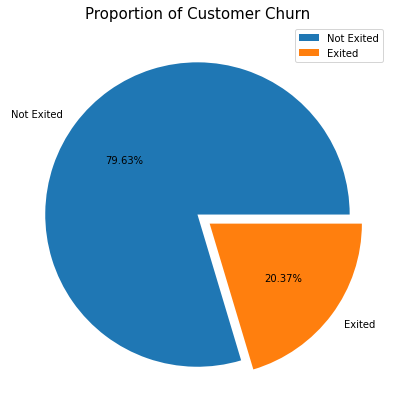

In [ ]:
plt.figure(figsize=(7,7))
plt.pie(df["Exited"].value_counts().values,labels=['Not Exited', 'Exited'],autopct='%1.2f%%',explode=(0, 0.1))
plt.title('Proportion of Customer Churn',color='black',fontsize=15)
plt.legend(labels = ['Not Exited', 'Exited'], loc = "upper right")
plt.show()

### 2.2 Categorical predictors

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

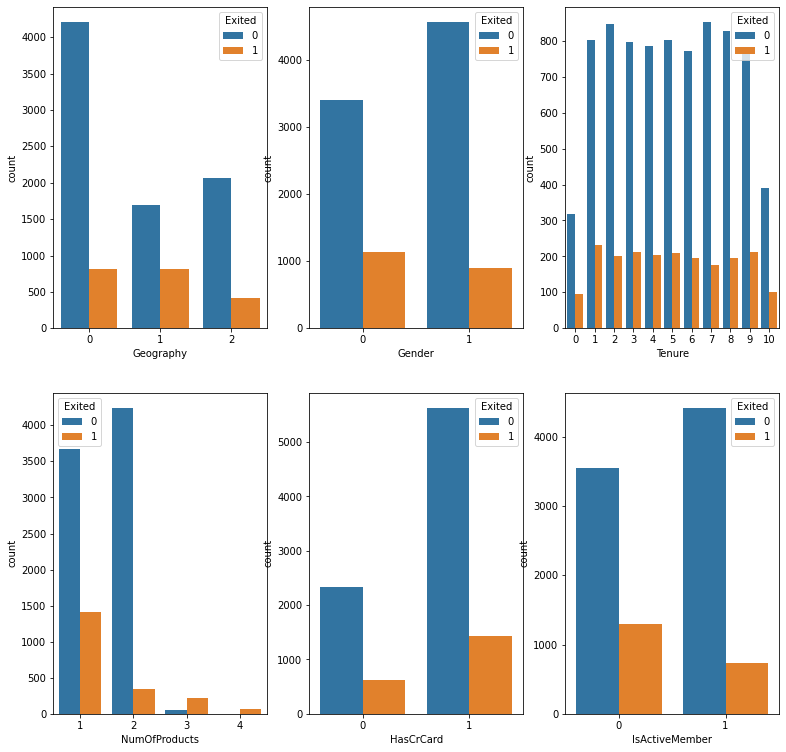

In [ ]:
fig, axarr = plt.subplots(2, 3, figsize=(13, 13))

#visulazie the count of Exited and NotExited for each feature

sns.countplot('Geography', hue = 'Exited',data = df, ax = axarr[0][0])
sns.countplot('Gender', hue = 'Exited',data = df, ax = axarr[0][1])
sns.countplot('Tenure', hue = 'Exited',data = df, ax = axarr[0][2])
sns.countplot('NumOfProducts', hue = 'Exited',data = df, ax = axarr[1][0])
sns.countplot('HasCrCard', hue = 'Exited',data = df, ax = axarr[1][1])
sns.countplot('IsActiveMember', hue = 'Exited',data = df, ax = axarr[1][2])


In [ ]:
# Hypothesis test
# H0: the predictor has no significant correlation with target
categorical_list = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
result = []
for x in categorical_list:
  a = pd.crosstab(df[x], df['Exited'])
  chi2, p, chi_df, expected = stats.chi2_contingency(a, correction=False) 
  value = stats.chi2.ppf(0.95, df=chi_df)
  if chi2>value:
    print('Reject H0: The', x, 'is significantly correlated with target, p value is:', p)
    result.append(x)
  else:
    print('Accept H0: The', x, 'is not significantly correlated with target, p value is:',p)

print('Significant variables:', result)


Reject H0: The Geography is significantly correlated with target, p value is: 3.8303176053541544e-66
Reject H0: The Gender is significantly correlated with target, p value is: 1.7204149874840846e-26
Accept H0: The Tenure is not significantly correlated with target, p value is: 0.17758462026413294
Reject H0: The NumOfProducts is significantly correlated with target, p value is: 0.0
Accept H0: The HasCrCard is not significantly correlated with target, p value is: 0.475365355970654
Reject H0: The IsActiveMember is significantly correlated with target, p value is: 5.953852540364001e-55
Significant variables: ['Geography', 'Gender', 'NumOfProducts', 'IsActiveMember']


### 2.3 Numerical predictors

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

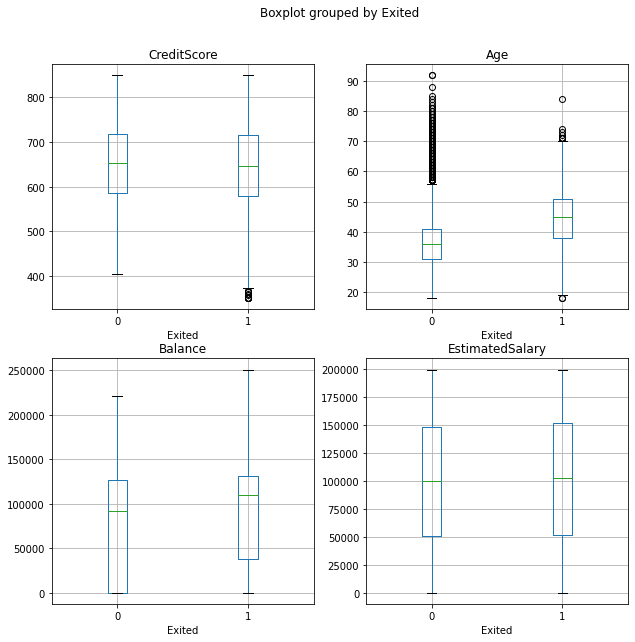

In [ ]:
# Boxplot
fig, axarr = plt.subplots(2, 2, figsize=(10, 10))
plt.title('Boxplot of numerical predictors',color='black',fontsize=15)
#categorical_column = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
df.boxplot(column = 'CreditScore', by = 'Exited', ax=axarr[0][0])
df.boxplot(column = 'Age', by = 'Exited', ax=axarr[0][1])
df.boxplot(column = 'Balance', by = 'Exited', ax=axarr[1][0])
df.boxplot(column = 'EstimatedSalary', by = 'Exited', ax=axarr[1][1])

plt.show()

In [ ]:
# check outliers in statistics: alpha=0.05
numeric_list = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary'] 
for i in numeric_list:
  mean = df[i].mean()
  std = df[i].std()
  lower = mean - 3 * std
  upper = mean + 3 * std
  print(i, len(df[(df[i] < lower) | (df[i] > upper)]))

CreditScore 8
Age 133
Balance 0
EstimatedSalary 0


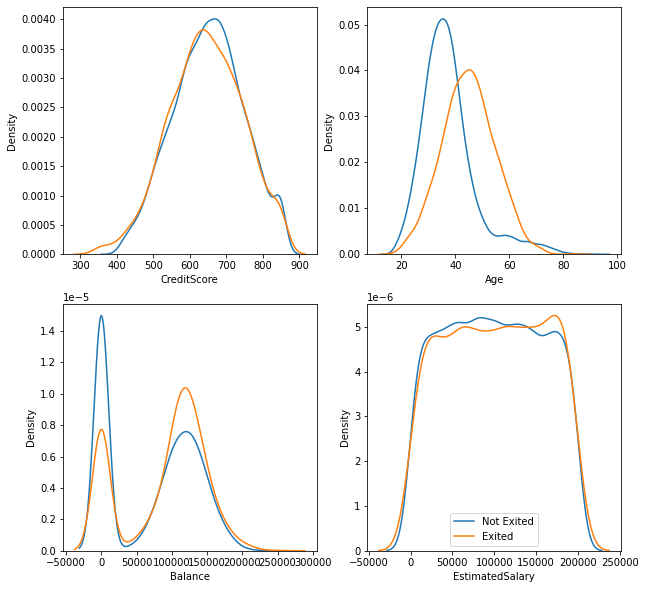

In [ ]:
# kdeplot

fig, axarr = plt.subplots(2, 2, figsize=(10, 10))

sns.kdeplot(df[df['Exited']==0]['CreditScore'],ax=axarr[0][0], label='Not Exited')
sns.kdeplot(df[df['Exited']==1]['CreditScore'],ax=axarr[0][0], label='Exited')
sns.kdeplot(df[df['Exited']==0]['Age'],ax=axarr[0][1], label='Not Exited')
sns.kdeplot(df[df['Exited']==1]['Age'],ax=axarr[0][1], label='Exited')
sns.kdeplot(df[df['Exited']==0]['Balance'],ax=axarr[1][0], label='Not Exited')
sns.kdeplot(df[df['Exited']==1]['Balance'],ax=axarr[1][0], label='Exited')
sns.kdeplot(df[df['Exited']==0]['EstimatedSalary'],ax=axarr[1][1], label='Not Exited')
sns.kdeplot(df[df['Exited']==1]['EstimatedSalary'],ax=axarr[1][1], label='Exited')

plt.legend()
plt.show()

In [ ]:
# point biserial test
numeric_list = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
for i in numeric_list:
  stats.pointbiserialr(df[i], df['Exited'])
  print(i,'--', stats.pointbiserialr(df[i], df['Exited']))

CreditScore -- PointbiserialrResult(correlation=-0.02709353975465779, pvalue=0.006738213892225283)
Age -- PointbiserialrResult(correlation=0.28532303783506824, pvalue=1.2399313093495365e-186)
Balance -- PointbiserialrResult(correlation=0.118532768771634, pvalue=1.275563319158762e-32)
EstimatedSalary -- PointbiserialrResult(correlation=0.012096861026844645, pvalue=0.2264404280235202)


### 2.4 Heatmap

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 <a list of 11 Text major ticklabel objects>)

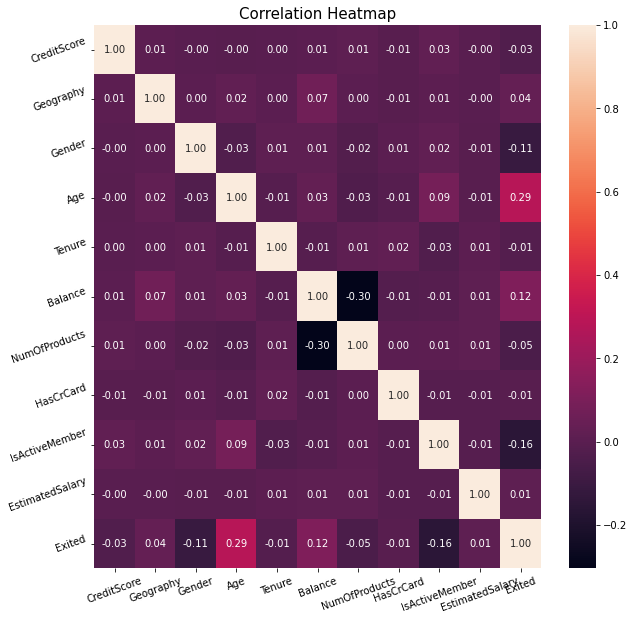

In [ ]:
# Pearson correlation coefficient 
cor = df.corr()
plt.figure(figsize=(10, 10))
plt.title('Correlation Heatmap',color='black',fontsize=15)
ax = sns.heatmap(cor, annot=True, fmt=".2f")
plt.yticks(rotation=20)
plt.xticks(rotation=20) 

# 3. Data preparation

In [ ]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


### 3.1 Data partitioning

In [ ]:
# split into 80% training data 20% validation data
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df['Exited'], test_size=0.25, random_state=0)
X_train_b = X_train
X_test_b = X_test
X_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
2967,579,1,0,39,5,117833.30,3,0,0,5831.00
700,750,0,0,32,5,0.00,2,1,0,95611.47
3481,729,2,0,34,9,53299.96,2,1,1,42855.97
1621,689,2,1,38,5,75075.14,1,1,1,8651.92
800,605,0,1,52,7,0.00,2,1,1,173952.50


### 3.2 Oversample

In [ ]:
#oversample
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train_b, y_train)

In [ ]:
y_train.value_counts()

0    5972
1    1528
Name: Exited, dtype: int64

In [ ]:
y_resampled.value_counts()

0    5972
1    5972
Name: Exited, dtype: int64

### 3.2 Scaling

In [ ]:
ss = StandardScaler()
ss.fit(X_train)
X_train = pd.DataFrame(ss.transform(X_train))
X_test = pd.DataFrame(ss.transform(X_test))
X_train.columns = df.columns[:10]
X_test.columns = df.columns[:10]
X_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,-0.735507,0.312661,-1.087261,0.015266,0.008860,0.673160,2.535034,-1.553624,-1.034460,-1.640810
1,1.024427,-0.892353,-1.087261,-0.652609,0.008860,-1.207724,0.804242,0.643657,-1.034460,-0.079272
2,0.808295,1.517675,-1.087261,-0.461788,1.393293,-0.356937,0.804242,0.643657,0.966688,-0.996840
3,0.396614,1.517675,0.919743,-0.080145,0.008860,-0.009356,-0.926551,0.643657,0.966688,-1.591746
4,-0.467915,-0.892353,0.919743,1.255605,0.701077,-1.207724,0.804242,0.643657,0.966688,1.283302


# 4. Model exploration and model selection

In [ ]:
# PCA
pca=PCA()
pca.fit(pd.DataFrame(ss.fit_transform(df)))
# explained variance
print ("Explained Variance:")
print (pca.explained_variance_) 

# proportion variance
print ("Proportion Variance:")
print (pca.explained_variance_ratio_) 

# cummulative proportion of variance
print ("Cumulative Proportion of Variance:")
print (np.cumsum(pca.explained_variance_ratio_))

Explained Variance:
[1.43832749 1.22089134 1.09668607 1.02056709 1.01506852 0.99521995
 0.99035423 0.97162148 0.94526441 0.69713447 0.60996505]
Proportion Variance:
[0.13074397 0.11097902 0.09968876 0.09276955 0.09226973 0.09046549
 0.0900232  0.08832039 0.08592453 0.06336952 0.05544582]
Cumulative Proportion of Variance:
[0.13074397 0.24172299 0.34141176 0.4341813  0.52645103 0.61691653
 0.70693973 0.79526012 0.88118465 0.94455418 1.        ]


In [ ]:
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

## 4.1 Logistic Regression

### 4.1.1 Logistic Regression(balanced)

In [ ]:
model_lr1=LogisticRegression(random_state=0,max_iter=10000,class_weight='balanced')
model_lr1.fit(X_train,y_train)
parameters = {'C':[0.8,0.9,1,1.1,1.2]}
              #'penalty':('l1', 'l2','elasticnet','none'),
              #'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
model_le_grid = GridSearchCV(model_lr1, parameters,cv=10,verbose=1,n_jobs=-1).fit(X_train,y_train)
print('Best parameters:',model_le_grid.best_params_)
\
print('Logistic Regression Train score:',model_lr1.score(X_train,y_train)*100)
print('Logistic Regression Cros validation score:',model_le_grid.best_score_*100)


Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best parameters: {'C': 0.8}
Logistic Regression Train score: 70.08
Logistic Regression Cros validation score: 69.89333333333335


In [ ]:
# training the model
lr1 = LogisticRegression(random_state = 0, C = 0.8,class_weight='balanced')
lr1.fit(X_train, y_train)

# testing the model

y_predict = lr1.predict(X_test)

              precision    recall  f1-score   support

           0       0.90      0.69      0.78      1991
           1       0.37      0.72      0.49       509

    accuracy                           0.70      2500
   macro avg       0.64      0.70      0.64      2500
weighted avg       0.80      0.70      0.72      2500



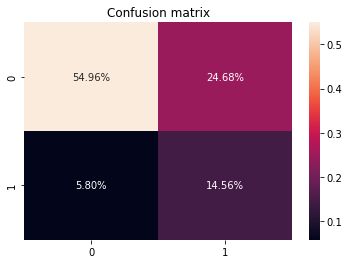

In [ ]:
evaluate_model(lr1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


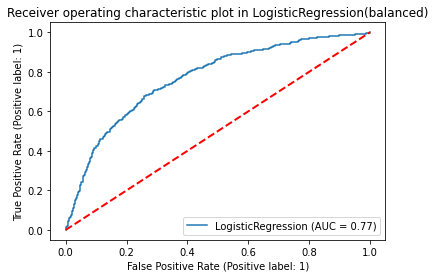

In [ ]:
plot_roc_curve(lr1, X_test, y_test) 
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--') 
plt.title('Receiver operating characteristic plot in LogisticRegression(balanced)')
plt.show()

In [ ]:
# tune the cut-off value
lr1 = LogisticRegression(random_state = 0, C = 0.8,class_weight='balanced')
lr1.fit(X_train, y_train)
logit_probability = lr1.predict_proba(X_train)
# p1: the probability of class 1
p1 = []
for i in range(0,len(logit_probability)):
  p1.append(logit_probability[i,1])

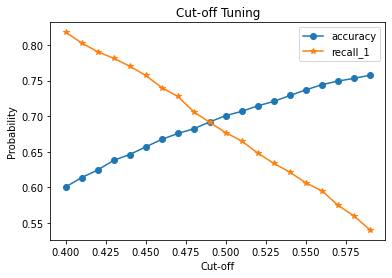

In [ ]:
cutoff=[]
recall_1=[]
acc_lr=[]
for j in np.arange(0.4,0.6,0.01):
  cutoff.append(j)
  a=[]
  for i in range(0,len(p1)):
    if p1[i]>j:
      a.append(1)
    else:
      a.append(0)
  logit_result = pd.DataFrame({'actual':y_train,
                               'y_new':a})
  
  TP = ((logit_result.y_new == 1) & (y_train == 1)).sum()
  FN = ((logit_result.y_new == 0) & (y_train == 1)).sum()
  TN = ((logit_result.y_new == 0) & (y_train == 0)).sum()
  FP = ((logit_result.y_new == 1) & (y_train == 0)).sum()

  acc = (TP + TN) / (TP + TN + FP + FN)
  recall = TP / (TP + FN)
  recall_1.append(recall)
  acc_lr.append(acc)
cutofftune = pd.DataFrame({'cutoff':cutoff,
                           'recall_1':recall_1,
                           'accuracy':acc_lr})
plt.plot(cutofftune['cutoff'],cutofftune['accuracy'],marker='o', label='accuracy')
plt.plot(cutofftune['cutoff'],cutofftune['recall_1'],marker='*', label='recall_1')
plt.legend()
plt.xlabel("Cut-off") 
plt.ylabel("Probability") 
plt.title("Cut-off Tuning") 
plt.show()

In [ ]:
# cut-off = 0.49
logit_probability = lr1.predict_proba(X_test)
# p1: the probability of class 1
p1 = []
for i in range(0,len(logit_probability)):
  p1.append(logit_probability[i,1])

a=[]
for i in range(0,len(p1)):
    if p1[i]>0.49:
      a.append(1)
    else:
      a.append(0)
logit_result = pd.DataFrame({'actual':y_test,
                               'y_new':a})
TP = ((logit_result.y_new == 1) & (y_test == 1)).sum()
TN = ((logit_result.y_new == 0) & (y_test == 0)).sum()
FP = ((logit_result.y_new == 1) & (y_test == 0)).sum()
FN = ((logit_result.y_new == 0) & (y_test == 1)).sum()
acc_lr = (TP + TN) / (TP + TN + FP + FN)
recall_1 = TP / (TP + FN)
precision_1 = TP / (TP + FP)
f1_lr_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1)
recall_0 = TN / (TN + FP)
precision_0 = TN / (TN + FN)
f1_lr_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0)
print('class of interest:',acc_lr, recall_1, precision_1, f1_lr_1)
print('class of non-interest:',acc_lr, recall_0, precision_0, f1_lr_0)

class of interest: 0.6864 0.7229862475442044 0.3639960435212661 0.4842105263157895
class of non-interest: 0.6864 0.6770467101958815 0.9053055742108798 0.7747126436781608


### 4.1.2 Logistic Regression(imbalanced)

In [ ]:
model_lr2=LogisticRegression(random_state=0,max_iter=10000)
model_lr2.fit(X_train,y_train)
parameters = {'C':[0.8,0.9,1,1.1,1.2]}
              #'penalty':('l1', 'l2','elasticnet','none'),
              #'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
model_le_grid = GridSearchCV(model_lr2, parameters,cv=10,verbose=1,n_jobs=-1).fit(X_train,y_train)
print('Best parameters:',model_le_grid.best_params_)

print('Logistic Regression Train score:',model_lr2.score(X_train,y_train)*100)
print('Logistic Regression Cros validation score:',model_le_grid.best_score_*100)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best parameters: {'C': 0.8}
Logistic Regression Train score: 80.93333333333334
Logistic Regression Cros validation score: 80.90666666666667


In [ ]:
# training the model
lr2 = LogisticRegression(random_state = 0, C = 0.8)
lr2.fit(X_train, y_train)

# testing the model

y_predict = lr2.predict(X_test)

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1991
           1       0.57      0.17      0.26       509

    accuracy                           0.80      2500
   macro avg       0.69      0.57      0.57      2500
weighted avg       0.77      0.80      0.76      2500



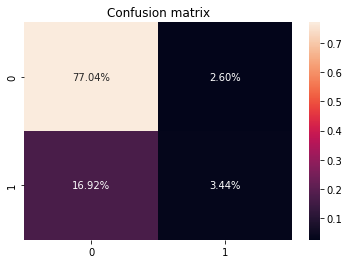

In [ ]:
evaluate_model(lr2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


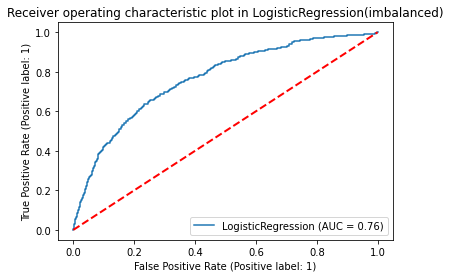

In [ ]:
plot_roc_curve(lr2, X_test, y_test) 
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--') 
plt.title('Receiver operating characteristic plot in LogisticRegression(imbalanced)')
plt.show()

## 4.2 Naive Bayes

In [ ]:
# bin numeric variables
X_train_b.CreditScore = [round(t/100) for t in X_train_b.CreditScore]
X_train_b.Age = [round(t/10) for t in X_train_b.Age]
X_train_b.Balance = [round(t/10000) for t in X_train_b.Balance]
X_train_b.EstimatedSalary = [round(t/10000) for t in X_train_b.EstimatedSalary]
X_train_b.CreditScore = X_train_b.CreditScore.astype('category')
X_train_b.Age = X_train_b.Age.astype('category')
X_train_b.Balance = X_train_b.Balance.astype('category')
X_train_b.EstimatedSalary = X_train_b.EstimatedSalary.astype('category')
X_train_b.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
2967,6,1,0,4,5,12,3,0,0,1
700,8,0,0,3,5,0,2,1,0,10
3481,7,2,0,3,9,5,2,1,1,4
1621,7,2,1,4,5,8,1,1,1,1
800,6,0,1,5,7,0,2,1,1,17


In [ ]:
# bin numeric variables
X_test_b.CreditScore = [round(t/100) for t in X_test_b.CreditScore]
X_test_b.Age = [round(t/10) for t in X_test_b.Age]
X_test_b.Balance = [round(t/10000) for t in X_test_b.Balance]
X_test_b.EstimatedSalary = [round(t/10000) for t in X_test_b.EstimatedSalary]
X_test_b.CreditScore = X_test_b.CreditScore.astype('category')
X_test_b.Age = X_test_b.Age.astype('category')
X_test_b.Balance = X_test_b.Balance.astype('category')
X_test_b.EstimatedSalary = X_test_b.EstimatedSalary.astype('category')
X_test_b.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
9394,6,1,0,4,8,13,1,1,1,19
898,5,0,0,4,2,10,1,1,0,13
2398,7,2,0,4,8,10,1,1,1,8
5906,8,0,1,3,4,11,1,0,0,9
2343,7,1,1,4,5,16,2,1,1,14


In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train_b, y_train)
y_predict = mnb.predict(X_test_b) 

0.7656 0.14734774066797643 0.3303964757709251 0.20380434782608697


              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1991
           1       0.33      0.15      0.20       509

    accuracy                           0.77      2500
   macro avg       0.57      0.54      0.53      2500
weighted avg       0.71      0.77      0.73      2500



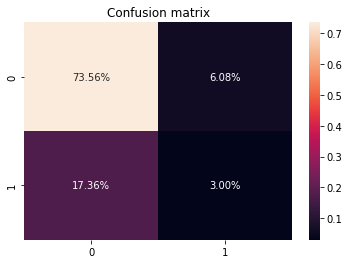

In [ ]:
evaluate_model(mnb)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


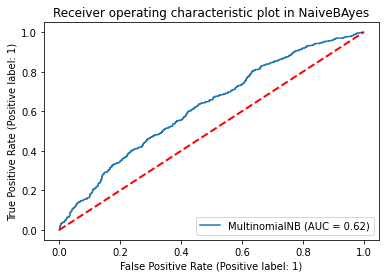

In [ ]:
plot_roc_curve(mnb, X_test_b, y_test) 
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--') 
plt.title('Receiver operating characteristic plot in NaiveBAyes')
plt.show()

## 4.3 SVM

### 4.3.1 SVM(balanced)

In [ ]:
model_svm=svm.SVC(random_state=0, class_weight='balanced')
parameters = {'kernel':('linear', 'rbf','poly'), 'C':[0.8,0.9,1,1.1,1.2],'degree':[3,4,5,6]}
model_svm_grid = GridSearchCV(model_svm, parameters,cv=10,verbose=1,n_jobs=-1).fit(X_train,y_train)
print('Best parameters:',model_svm_grid.best_params_)
print('Support Vecktor Classification Cros validation score:',model_svm_grid.best_score_*100)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
Best parameters: {'C': 0.8, 'degree': 6, 'kernel': 'poly'}
Support Vecktor Classification Cros validation score: 81.18666666666667


In [ ]:
svm1 = svm.SVC(kernel='poly', C=0.8, degree=6, class_weight='balanced') 

svm1.fit(X_train, y_train)
score = svm1.score(X_train, y_train)

#Predict Output
y_predict= svm1.predict(X_test)

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      1991
           1       0.54      0.56      0.55       509

    accuracy                           0.81      2500
   macro avg       0.71      0.72      0.72      2500
weighted avg       0.82      0.81      0.81      2500



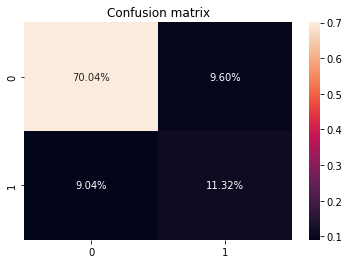

In [ ]:
evaluate_model(svm1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


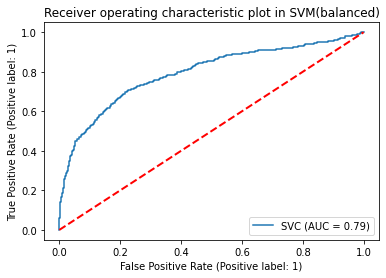

In [ ]:
plot_roc_curve(svm1, X_test, y_test) 
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--') 
plt.title('Receiver operating characteristic plot in SVM(balanced)')
plt.show()

### 4.3.2 SVM(imbalanced)

In [ ]:
model_svm_2 = svm.SVC(random_state=0)
parameters = {'kernel':('linear', 'rbf','poly'), 'C':[0.8,0.9,1,1.1,1.2],'degree':[3,4,5,6]}
model_svm_grid = GridSearchCV(model_svm_2, parameters,cv=10,verbose=1,n_jobs=-1).fit(X_train,y_train)
print('Best parameters:',model_svm_grid.best_params_)
print('Support Vecktor Classification Cros validation score:',model_svm_grid.best_score_*100)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
Best parameters: {'C': 1.2, 'degree': 3, 'kernel': 'rbf'}
Support Vecktor Classification Cros validation score: 85.26666666666667


In [ ]:
svm2 = svm.SVC(kernel='rbf', C=1.2, degree=3) 

svm2.fit(X_train, y_train)
score = svm2.score(X_train, y_train)

#Predict Output
y_predict= svm2.predict(X_test)

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1991
           1       0.82      0.41      0.54       509

    accuracy                           0.86      2500
   macro avg       0.84      0.69      0.73      2500
weighted avg       0.86      0.86      0.84      2500



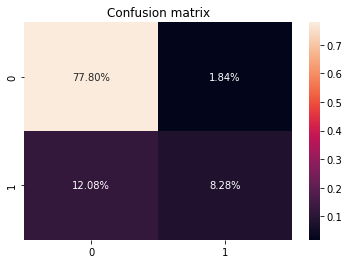

In [ ]:
evaluate_model(svm2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


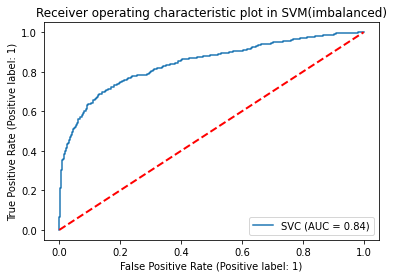

In [ ]:
plot_roc_curve(svm2, X_test, y_test) 
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--') 
plt.title('Receiver operating characteristic plot in SVM(imbalanced)')
plt.show()

## 4.4 Decision Tree

### 4.4.1 Decision Tree(balanced)

In [ ]:
#oversample
params = {'splitter':('best','random'),
              'criterion':('gini', 'entropy'),
              'max_depth': [*range(1,10)],
              'min_samples_leaf':[*range(1,50,5)],
              'min_impurity_decrease':[*np.linspace(0, 0.5, 20)]}

dt = DecisionTreeClassifier()
clf_os = GridSearchCV(dt, params, scoring='roc_auc', cv=5, n_jobs=-1 ,verbose = 1)
search = clf_os.fit(X_resampled, y_resampled)

print('Best parameters:',search.best_params_)
print('Cros validation score:',search.best_score_*100)

Fitting 5 folds for each of 7200 candidates, totalling 36000 fits
Best parameters: {'criterion': 'gini', 'max_depth': 9, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'splitter': 'best'}
Cros validation score: 89.7200503427078


In [ ]:
#oversample
X_resampled, y_resampled
clf_os = DecisionTreeClassifier(criterion='gini',
                                max_depth=9,
                                min_samples_leaf = 1,
                                splitter='best')
clf_os.fit(X_resampled, y_resampled)

DecisionTreeClassifier(max_depth=9)

              precision    recall  f1-score   support

           0       0.91      0.77      0.84      1991
           1       0.44      0.70      0.54       509

    accuracy                           0.76      2500
   macro avg       0.68      0.74      0.69      2500
weighted avg       0.81      0.76      0.78      2500



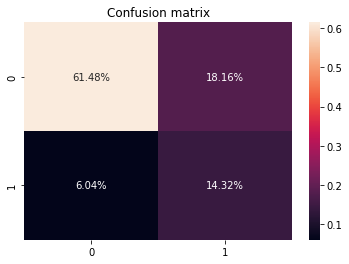

In [ ]:
evaluate_model(clf_os)#oversample

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


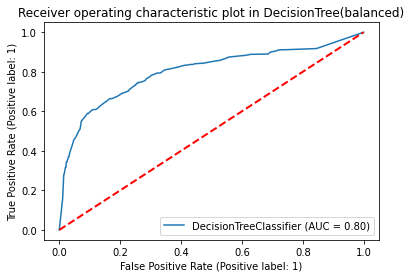

In [ ]:
plot_roc_curve(clf_os, X_test_b, y_test) 
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--') 
plt.title('Receiver operating characteristic plot in DecisionTree(balanced)')
plt.show()#oversample

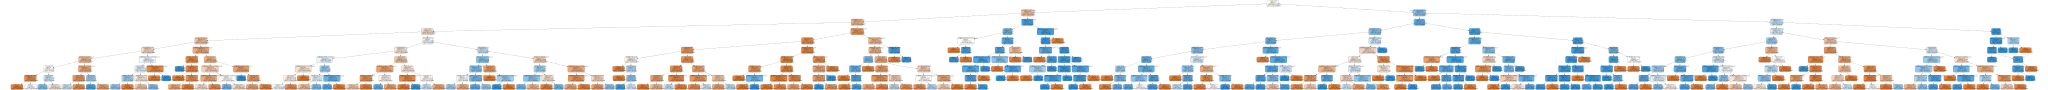

<Figure size 720x720 with 0 Axes>

In [ ]:
import graphviz 
plt.figure(figsize=(10,10))
dot_data = tree.export_graphviz(clf_os, out_file=None, 
                     feature_names=X_train_b.columns,  
                     class_names={0:'NOT EXITED', 1:'EXITED'},  
                     filled=True, rounded=True,  
                     special_characters=True)  

graph = graphviz.Source(dot_data)  
graph 

### 4.4.2 Decision Tree(imbalanced)

In [ ]:
dt = DecisionTreeClassifier(random_state = 0)
parameters = {'splitter':('best','random'),
              'criterion':('gini', 'entropy'),
              'max_depth': [*range(1,10)],
              'min_samples_leaf':[*range(1,50,5)],
              'min_impurity_decrease':[*np.linspace(0, 0.5, 20)]}

GS2 = GridSearchCV(dt, parameters, cv=10).fit(X_train_b,y_train)
print('Best parameters:',GS2.best_params_)
print('Support Vecktor Classification Cros validation score:',GS2.best_score_*100)

Best parameters: {'criterion': 'gini', 'max_depth': 8, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 26, 'splitter': 'best'}
Support Vecktor Classification Cros validation score: 85.64


In [ ]:
clf3 = DecisionTreeClassifier(criterion='gini',
                              max_depth=8,
                              min_samples_leaf=26,
                              splitter='best')
clf3.fit(X_train_b, y_train)
score = clf3.score(X_train_b, y_train)
y_predict= clf3.predict(X_test_b)

              precision    recall  f1-score   support

           0       0.82      0.99      0.90      1991
           1       0.86      0.14      0.24       509

    accuracy                           0.82      2500
   macro avg       0.84      0.57      0.57      2500
weighted avg       0.83      0.82      0.76      2500



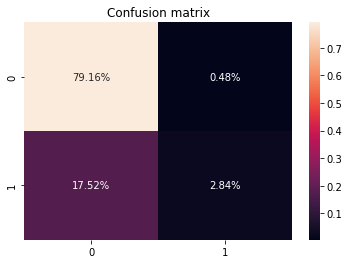

In [ ]:
evaluate_model(clf3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


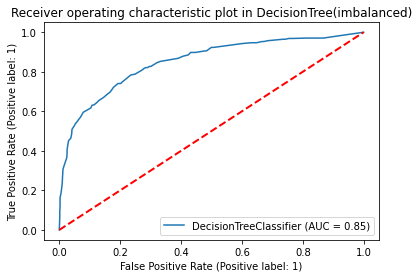

In [ ]:
plot_roc_curve(clf3, X_test_b, y_test) 
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--') 
plt.title('Receiver operating characteristic plot in DecisionTree(imbalanced)')
plt.show()

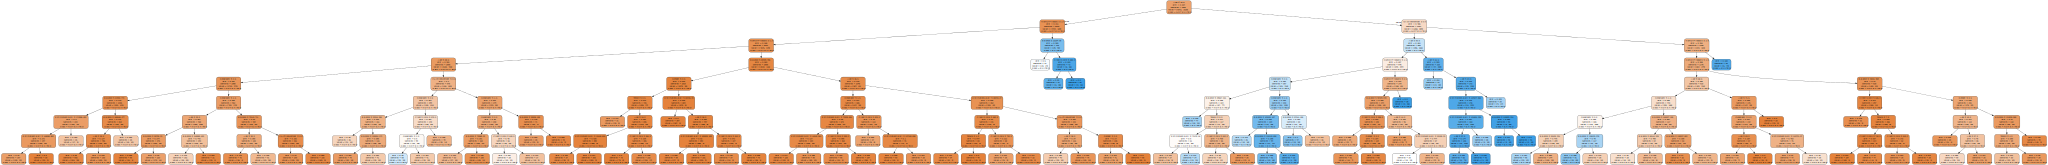

In [ ]:
import graphviz 
dot_data = tree.export_graphviz(clf3, out_file=None, 
                     feature_names=X_train_b.columns,  
                     class_names={0:'NOT EXITED', 1:'EXITED'},  
                     filled=True, rounded=True,  
                     special_characters=True)  

graph = graphviz.Source(dot_data)  
graph 

## 4.5 Random Forest

### 4.5.1 Random Forest(balanced)

In [ ]:
params = {'n_estimators':range(10,200,10),
          'max_depth':range(2,14,2),
          'min_samples_split':range(10,200,20)}
rf = RandomizedSearchCV(RandomForestClassifier(random_state = 0, class_weight='balanced'), params, n_iter=300, scoring='roc_auc', n_jobs=-1, cv=5, verbose=1, random_state = 0)
rf.fit(X_train,y_train)
rf.best_params_, rf.best_score_

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


({'max_depth': 10, 'min_samples_split': 30, 'n_estimators': 160},
 0.8611668184369634)

              precision    recall  f1-score   support

           0       0.93      0.85      0.89      1991
           1       0.56      0.74      0.64       509

    accuracy                           0.83      2500
   macro avg       0.74      0.79      0.76      2500
weighted avg       0.85      0.83      0.84      2500



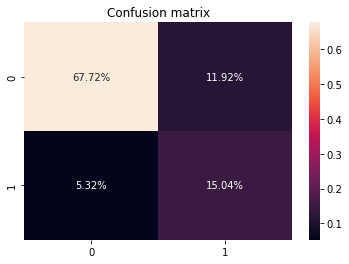

In [ ]:
evaluate_model(rf)

In [ ]:
importances = rf.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
labels = df.columns[:10]
for f in range(X_train.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30, labels[indices[f]], importances[indices[f]]))

 1) Age                            0.341226
 2) NumOfProducts                  0.237877
 3) Balance                        0.117278
 4) EstimatedSalary                0.068475
 5) CreditScore                    0.067412
 6) IsActiveMember                 0.054432
 7) Geography                      0.046870
 8) Tenure                         0.036044
 9) Gender                         0.023904
10) HasCrCard                      0.006483


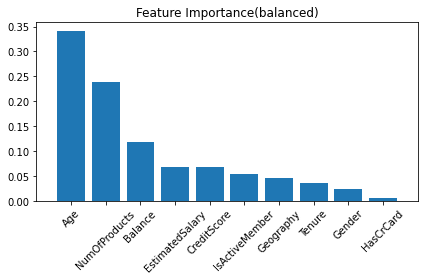

In [ ]:
plt.title('Feature Importance(balanced)')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]),
           labels[indices], rotation=45)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


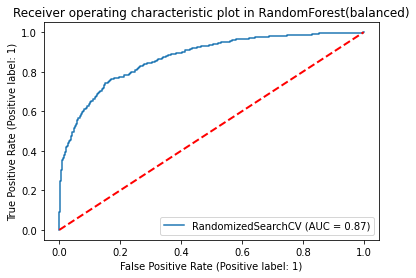

In [ ]:
plot_roc_curve(rf, X_test, y_test) 
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--') 
plt.title('Receiver operating characteristic plot in RandomForest(balanced)')
plt.show()

### 4.5.2 Random Forest(imbalanced)

In [ ]:
params = {'n_estimators':range(10,200,10),
          'max_depth':range(2,14,2),
          'min_samples_split':range(10,200,20)}
rf = RandomizedSearchCV(RandomForestClassifier(), params, n_iter=300, scoring='roc_auc', n_jobs=-1, cv=5, verbose=1)
rf.fit(X_train,y_train)
rf.best_params_, rf.best_score_

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


({'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 120},
 0.8577589825539602)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1991
           1       0.79      0.49      0.60       509

    accuracy                           0.87      2500
   macro avg       0.83      0.73      0.76      2500
weighted avg       0.86      0.87      0.86      2500



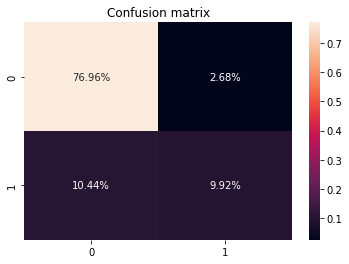

In [ ]:
evaluate_model(rf)

In [ ]:
importances = rf.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
labels = df.columns[:10]
for f in range(X_train.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30, labels[indices[f]], importances[indices[f]]))

 1) Age                            0.332117
 2) NumOfProducts                  0.238979
 3) Balance                        0.103059
 4) CreditScore                    0.079990
 5) EstimatedSalary                0.077854
 6) IsActiveMember                 0.065783
 7) Geography                      0.039468
 8) Tenure                         0.036983
 9) Gender                         0.018342
10) HasCrCard                      0.007425


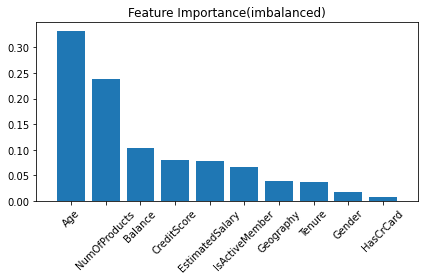

In [ ]:
plt.title('Feature Importance(imbalanced)')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]),
           labels[indices], rotation=45)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


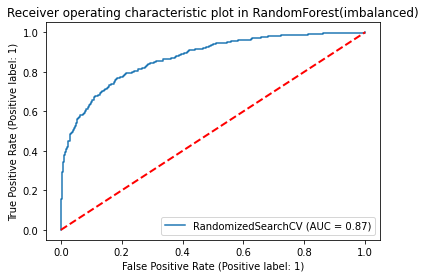

In [ ]:
plot_roc_curve(rf, X_test, y_test) 
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--') 
plt.title('Receiver operating characteristic plot in RandomForest(imbalanced)')
plt.show()

## 4.6 KNN

In [ ]:
score = []
opt_score = 0
opt_k = 0
for i in range(1,11):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train, y_train) 
  s = knn.score(X_test, y_test)
  if(opt_score < s):
    opt_score = s
    opt_k = i
  score.append(s)
print(score)
print(opt_k,' ', opt_score)

[0.798, 0.8384, 0.8272, 0.8364, 0.8384, 0.8432, 0.8416, 0.8412, 0.8436, 0.8424]
9   0.8436


In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      1991
           1       0.76      0.33      0.46       509

    accuracy                           0.84      2500
   macro avg       0.80      0.65      0.68      2500
weighted avg       0.83      0.84      0.82      2500



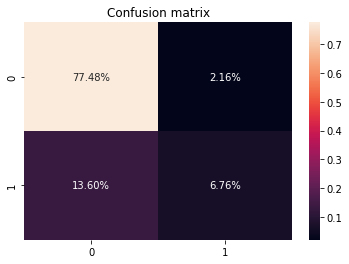

In [ ]:
evaluate_model(knn)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


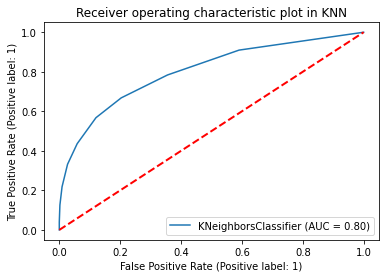

In [ ]:
plot_roc_curve(knn, X_test, y_test) 
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--') 
plt.title('Receiver operating characteristic plot in KNN')
plt.show()

## 4.7 Gradient Boosting

In [ ]:
params = {
    "learning_rate": [0.05,0.10,0.15,0.20,0.25,0.30],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3, 4, 5, 6, 8, 10, 12, 15]
}

classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

gb = RandomizedSearchCV(GradientBoostingClassifier(), params, n_iter = 300, cv=10, n_jobs=-1 ,verbose = 1)

gb.fit(X_train, y_train, sample_weight=classes_weights)
y_predict = gb.predict(X_test)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


In [ ]:
gb.best_params_, gb.best_score_#balanced

({'learning_rate': 0.25,
  'max_depth': 12,
  'min_samples_leaf': 0.1,
  'min_samples_split': 0.42727272727272736,
  'n_estimators': 10},
 0.7377333333333334)

In [ ]:
gb.best_params_, gb.best_score_

({'learning_rate': 0.25,
  'max_depth': 8,
  'min_samples_leaf': 0.1,
  'min_samples_split': 0.17272727272727273,
  'n_estimators': 10},
 0.8357333333333333)

              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1991
           1       0.42      0.71      0.53       509

    accuracy                           0.74      2500
   macro avg       0.67      0.73      0.67      2500
weighted avg       0.81      0.74      0.76      2500



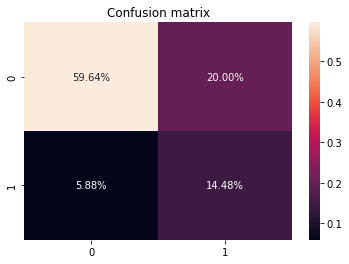

In [ ]:
evaluate_model(gb)#balanced

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1991
           1       0.74      0.37      0.49       509

    accuracy                           0.84      2500
   macro avg       0.80      0.67      0.70      2500
weighted avg       0.83      0.84      0.82      2500



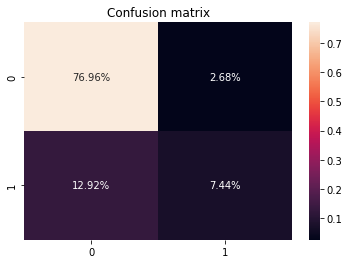

In [ ]:
evaluate_model(gb)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


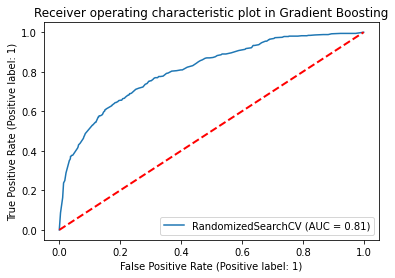

In [ ]:
plot_roc_curve(gb, X_test, y_test) 
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--') 
plt.title('Receiver operating characteristic plot in Gradient Boosting')
plt.show()#balanced

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


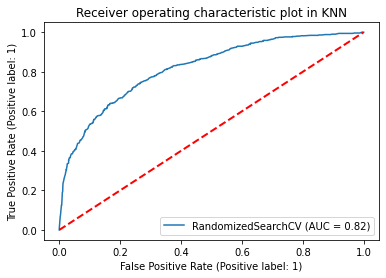

In [ ]:
plot_roc_curve(gb, X_test, y_test) 
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--') 
plt.title('Receiver operating characteristic plot in Gradient Boosting')
plt.show()

## 4.8 XGboost

### 4.8.1 XGboost(balanced)

In [ ]:
weight = (y_train==0).sum() / (y_train==1).sum()
params = {
 'learning_rate':np.linspace(0.01,0.5,20),
 'max_depth':range(2,15,1),
 'min_child_weight':range(1,9,1),
 'gamma' : np.linspace(0.0,0.3),
 'colsample_bytree':np.linspace(0.5,0.98,10)
}

xgb = RandomizedSearchCV(XGBClassifier(random_state = 0, scale_pos_weight = weight), params, n_iter=300, scoring='roc_auc', n_jobs=-1, cv=5, verbose=1, random_state = 0)
xgb.fit(X_train, y_train)
y_predict = xgb.predict(X_test)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


In [ ]:
xgb.best_params_, xgb.best_score_

({'colsample_bytree': 0.8733333333333333,
  'gamma': 0.2755102040816326,
  'learning_rate': 0.08736842105263157,
  'max_depth': 3,
  'min_child_weight': 2},
 0.8615051738936581)

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      1991
           1       0.48      0.78      0.59       509

    accuracy                           0.78      2500
   macro avg       0.70      0.78      0.72      2500
weighted avg       0.84      0.78      0.80      2500



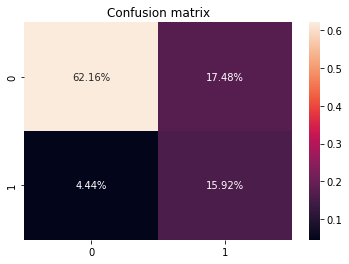

In [ ]:
evaluate_model(xgb)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


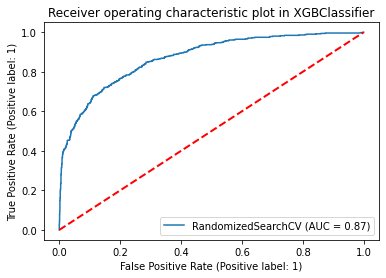

In [ ]:
plot_roc_curve(xgb, X_test, y_test) 
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--') 
plt.title('Receiver operating characteristic plot in XGBClassifier')
plt.show()

### 4.8.2 XGboost(imbalanced)

In [ ]:
params = {
 'learning_rate':np.linspace(0.01,0.5,20),
 'max_depth':range(2,15,1),
 'min_child_weight':range(1,9,1),
 'gamma' : np.linspace(0.0,0.3),
 'colsample_bytree':np.linspace(0.5,0.98,10)
}

xgb = RandomizedSearchCV(XGBClassifier(), params, n_iter=300, scoring='roc_auc', n_jobs=-1, cv=5, verbose=1)
xgb.fit(X_train, y_train)
y_predict = xgb.predict(X_test)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


In [ ]:
xgb.best_params_, xgb.best_score_

({'colsample_bytree': 0.6066666666666667,
  'gamma': 0.006122448979591836,
  'learning_rate': 0.06157894736842105,
  'max_depth': 6,
  'min_child_weight': 8},
 0.8624515039362824)

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1991
           1       0.75      0.50      0.60       509

    accuracy                           0.86      2500
   macro avg       0.82      0.73      0.76      2500
weighted avg       0.85      0.86      0.85      2500



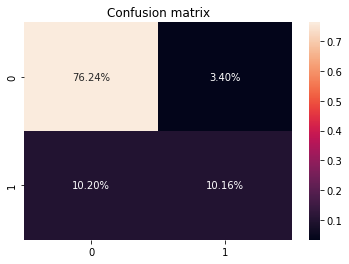

In [ ]:
evaluate_model(xgb)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


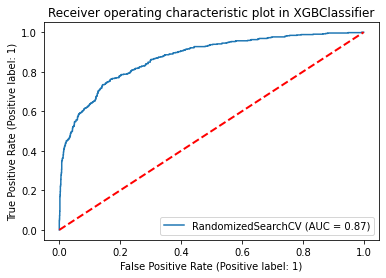

In [ ]:
plot_roc_curve(xgb, X_test, y_test) 
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--') 
plt.title('Receiver operating characteristic plot in XGBClassifier')
plt.show()

## 4.9 Neural Network

In [ ]:
model_mlp=MLPClassifier(max_iter=1000)
model_mlp.fit(X_train,y_train)
parameters = {'alpha':[0.0001,0.0005,0.001,0.005,0.01],
              'solver':('lbfgs', 'sgd', 'adam'),
              'activation':('identity', 'logistic', 'tanh', 'relu'),
              'hidden_layer_sizes':[(5,2),(8,4)]}
model_mlp_grid = RandomizedSearchCV(model_mlp, parameters,cv=5,verbose=1,n_jobs=-1).fit(X_train,y_train)
print('Best parameters:',model_mlp_grid.best_params_)

print('Logistic Regression Train score:',model_mlp.score(X_train,y_train)*100)
print('Logistic Regression Cros validation score:',model_mlp_grid.best_score_*100)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'solver': 'adam', 'hidden_layer_sizes': (8, 4), 'alpha': 0.005, 'activation': 'relu'}
Logistic Regression Train score: 88.64
Logistic Regression Cros validation score: 86.05333333333334


In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes = (8,8,8), max_iter=500, alpha=0.005, solver='lbfgs',activation='relu')
mlp.fit(X_train,y_train)

y_predict = mlp.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1991
           1       0.70      0.51      0.59       509

    accuracy                           0.86      2500
   macro avg       0.79      0.73      0.75      2500
weighted avg       0.85      0.86      0.85      2500



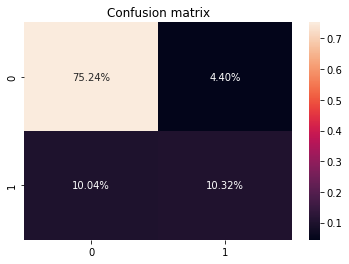

In [ ]:
evaluate_model(mlp)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


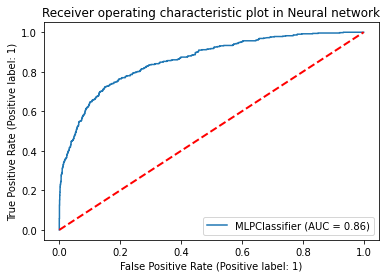

In [ ]:
plot_roc_curve(mlp, X_test, y_test) 
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--') 
plt.title('Receiver operating characteristic plot in Neural network')
plt.show()

# 5. Summary

In [ ]:
# balanced model
result_balanced = pd.DataFrame({'Models':['Logistic Regression','Naive Bayes','SVM','Decision Tree','Random Forest','XGBoosting','Neural Network'],
                       'recall':[0.72,0.00,0.56,0.7,0.74,0.78,0.00]})
result_balanced

,Models,recall
0,Logistic Regression,0.72
1,Naive Bayes,0.00
2,SVM,0.56
3,Decision Tree,0.70
4,Random Forest,0.74
5,XGBoosting,0.78
6,Neural Network,0.00


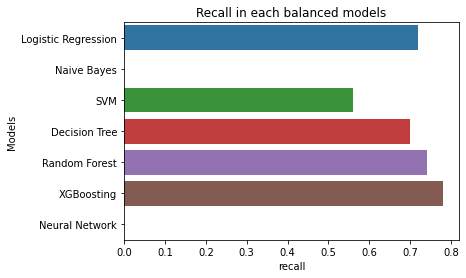

In [ ]:
sns.barplot(x=result_balanced['recall'],y=result_balanced['Models'],)
#plt.xticks(rotation=45)
plt.title('Recall in each balanced models')
plt.show()

In [ ]:
# imbalanced model
result_imbalanced = pd.DataFrame({'Models':['Logistic Regression','Naive Bayes','SVM','Decision Tree','Random Forest','XGBoosting','Neural Network'],
                       'accuracy':[0.77,0.80,0.86,0.82,0.87,0.86,0.86]})
result_imbalanced

,Models,accuracy
0,Logistic Regression,0.77
1,Naive Bayes,0.80
2,SVM,0.86
3,Decision Tree,0.82
4,Random Forest,0.87
5,XGBoosting,0.86
6,Neural Network,0.86


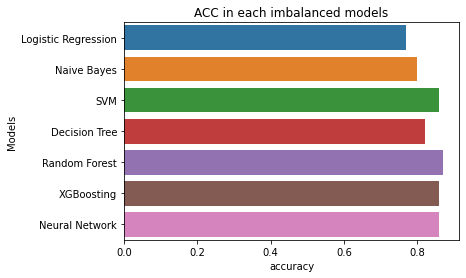

In [ ]:
sns.barplot(x=result_imbalanced['accuracy'],y=result_imbalanced['Models'],)
#plt.xticks(rotation=45)
plt.title('ACC in each imbalanced models')
plt.show()